# Bayesian-GIOP Retrieval for NOMAD Data

In this notebook cell, we implement a simplified version of the Bayesian-GIOP retrieval method described in Erickson et al. (2023). The purpose is to retrieve key inherent optical properties (IOPs) from observed ocean color data (i.e., water-leaving reflectance, Rrs) using a Bayesian optimal estimation (MAP) framework. 

The retrieval uses the following steps:
1. **Data Loading and Rrs Calculation:**  
   We load a NOMAD dataset (assumed to be in CSV format) and compute the remote-sensing reflectance (Rrs) at six SeaWiFS wavelengths by taking the ratio of spectral water-leaving radiance (`lw_λ`) to surface irradiance (`es_λ`).

2. **Forward Model Definition:**  
   A simplified GIOP forward model is defined that maps a state vector _x_ = [aph(443), adg(443), bbp(555), Sdg, η] to Rrs. This model uses:
   - A normalized exponential form for the phytoplankton absorption spectral shape.
   - An exponential decay function for the detrital/gelbstoff absorption.
   - A power-law for particulate backscattering.
   - A quasi-analytical radiative transfer approximation to convert absorption and backscattering into water-leaving reflectance.

3. **Jacobian Computation:**  
   The Jacobian of the forward model with respect to the retrieval parameters is estimated using finite differences. This is required to linearize the model around the current parameter estimate.

4. **Bayesian Optimal Estimation (MAP) Retrieval:**  
   An iterative MAP algorithm is used to update the parameter estimate. The algorithm minimizes the sum of the misfit between the modeled and observed Rrs (weighted by the measurement error covariance) and a penalty term for deviating from prior parameter estimates (weighted by the prior covariance). The retrieval outputs the maximum a posteriori (MAP) estimates of the parameters as well as the posterior covariance matrix (providing uncertainty estimates).

5. **Test with Simulated NOMAD Data:**  
   For demonstration purposes, a small test DataFrame is created with example values (simulated NOMAD record) for the required spectral bands. The observed Rrs spectrum is computed and used in the retrieval. Finally, the MAP estimates, their uncertainties, and the modeled Rrs based on the retrieved parameters are printed.

This cell is designed to serve both as an illustration of the retrieval process and as a basis for further adaptation to real NOMAD data.


In [19]:
import numpy as np
import pandas as pd
from loguru import logger

In [2]:

# -------------------------------
# 1. Data Loading and Rrs Computation
# -------------------------------

def load_nomad_data(filepath):
    """
    Load the NOMAD dataset CSV into a pandas DataFrame.
    Expected columns for wavelengths (nm):
      - lw_412, lw_443, lw_490, lw_510, lw_555, lw_670
      - es_412, es_443, es_490, es_510, es_555, es_670
    """
    df = pd.read_csv(filepath)
    return df

def compute_rrs_from_row(row, wavelengths=np.array([412, 443, 490, 510, 555, 670])):
    """
    Compute Rrs(λ) = lw(λ)/es(λ) at the specified wavelengths for one record.
    """
    rrs_obs = []
    for wl in wavelengths:
        lw_val = row[f'lw_{wl}']
        es_val = row[f'es_{wl}']
        rrs_val = lw_val / es_val if es_val != 0 else np.nan
        rrs_obs.append(rrs_val)
    return np.array(rrs_obs)


In [3]:
# -------------------------------
# 2. Forward Model Functions for Bayesian-GIOP
# -------------------------------

def a_star_ph(wavelengths):
    """
    Compute a normalized phytoplankton absorption shape.
    Using an exponential decay: a*_ph(λ) = exp(-k*(λ-443)), normalized at 443 nm.
    """
    k = 0.005  # decay constant (per nm)
    shape = np.exp(-k * (wavelengths - 443))
    # Normalize at 443 nm:
    norm = np.interp(443, wavelengths, shape)
    return shape / norm

def forward_model_GIOP(x, wavelengths, aw, bbw, g1=0.0949, g2=0.0794):
    """
    Compute modeled water-leaving reflectance (Rrs) from the state vector:
      x = [aph443, adg443, bbp555, Sdg, eta]
    """
    aph443, adg443, bbp555, Sdg, eta = x
    # Phytoplankton absorption:
    a_ph_shape = a_star_ph(wavelengths)
    a_ph = aph443 * a_ph_shape
    # Detrital+gelbstoff absorption (exponential form):
    a_dg = adg443 * np.exp(-Sdg * (wavelengths - 443))
    # Total absorption
    a_tot = aw + a_ph + a_dg
    # Particulate backscatter shape using power law:
    bbp_shape = (wavelengths / 555.0) ** (-eta)
    bbp = bbp_shape * bbp555
    # Total backscatter:
    bb_tot = bbw + bbp
    # Compute subsurface reflectance:
    u = bb_tot / (a_tot + bb_tot)
    rrs = g1 * u + g2 * (u ** 2)
    # Convert to above-surface Rrs:
    Rrs_model = 0.52 * rrs / (1 - 1.7 * rrs)
    return Rrs_model

def finite_diff_jacobian(func, x, eps=1e-6, *args):
    """
    Compute the Jacobian matrix of 'func' at x using finite differences.
    """
    x = np.atleast_1d(x)
    f0 = func(x, *args)
    n_params = x.size
    n_obs = f0.size
    J = np.zeros((n_obs, n_params))
    for j in range(n_params):
        x_pert = x.copy()
        delta = eps if x[j] == 0 else eps * abs(x[j])
        x_pert[j] += delta
        f_pert = func(x_pert, *args)
        J[:, j] = (f_pert - f0) / delta
    return J


In [12]:

# -------------------------------
# 3. Bayesian-GIOP Retrieval
# -------------------------------

def bayesian_giop_retrieval(Rrs_obs, x_prior, S_p, wavelengths, aw, bbw, g1=0.0949, g2=0.0794,
                            S_R_scalar=1e-8, tol=1e-6, max_iter=20):
    """
    Perform MAP retrieval using an iterative Bayesian optimal estimation.
    """
    m = wavelengths.size
    S_R = np.diag(S_R_scalar * np.ones(m))
    S_R_inv = np.linalg.inv(S_R)
    eps=1e-6
    x_est = x_prior.copy()
    for iteration in range(max_iter):
        F_x = forward_model_GIOP(x_est, wavelengths, aw, bbw, g1, g2)
        resid = Rrs_obs - F_x
        
        K = finite_diff_jacobian(forward_model_GIOP, x_est, eps, wavelengths, aw, bbw, g1, g2)
        S_p_inv = np.linalg.inv(S_p)
        A = K.T.dot(S_R_inv).dot(K) + S_p_inv
        S_post = np.linalg.inv(A)
        update_term = resid + K.dot(x_est - x_prior)
        x_new = x_prior + S_post.dot(K.T).dot(S_R_inv).dot(update_term)
        if np.linalg.norm(x_new - x_est) < tol:
            x_est = x_new
            print(f"Converged after {iteration+1} iterations.")
            break
        x_est = x_new
    else:
        print("Maximum iterations reached without convergence.")
    
    return x_est, S_post



In [20]:
# -------------------------------
# 4. Main Script with Test Data
# -------------------------------

def main():
    # Define the SeaWiFS wavelengths (nm)
    wavelengths = np.array([412, 443, 490, 510, 555, 670])
    
    # Define water absorption (aw) and backscatter (bbw) spectra (example values)
    aw = np.array([0.06, 0.07, 0.10, 0.12, 0.15, 0.30])  # m^-1
    bbw = np.array([0.003, 0.0025, 0.002, 0.0018, 0.0015, 0.001])  # m^-1
    
    # Simulate a minimal NOMAD record as a DataFrame (for testing)
    data = {
        'lw_412': [0.004], 'lw_443': [0.005], 'lw_490': [0.006],
        'lw_510': [0.007], 'lw_555': [0.005], 'lw_670': [0.003],
        'es_412': [10.0], 'es_443': [10.0], 'es_490': [10.0],
        'es_510': [10.0], 'es_555': [10.0], 'es_670': [10.0]
    }
    df_test = pd.DataFrame(data)
    
    # Use the first record as test case.
    sample_row = df_test.iloc[0]
    
    # Compute observed Rrs.
    Rrs_obs = compute_rrs_from_row(sample_row, wavelengths)
    print("Observed Rrs:", Rrs_obs)
    
    # -------------------------------
    # Set up the Bayesian retrieval.
    # -------------------------------
    # Retrieval vector: [aph443, adg443, bbp555, Sdg, eta]
    # Set prior based on typical values (these are example values inspired by the 2023 paper).
    x_prior = np.array([1.0, 0.04, 0.0029, 0.015, 1.4])
    # Prior standard deviations:
    prior_std = np.array([0.1, 0.005, 0.0005, 0.001, 0.1])
    S_p = np.diag(prior_std**2)
    
    # Assume measurement noise variance (for Rrs) ~ (1e-4)^2.
    S_R_scalar = 1e-8
    
    # Run the Bayesian-GIOP retrieval.
    x_map, S_post = bayesian_giop_retrieval(Rrs_obs, x_prior, S_p, wavelengths, aw, bbw,
                                            g1=0.0949, g2=0.0794, S_R_scalar=S_R_scalar)
    
    print("\nBayesian-GIOP MAP Results:")
    print(f"  aph(443): {x_map[0]:.4f} m^-1")
    print(f"  adg(443): {x_map[1]:.4f} m^-1")
    print(f"  bbp(555): {x_map[2]:.4f} m^-1")
    print(f"  Sdg:      {x_map[3]:.4f} nm^-1")
    print(f"  eta:      {x_map[4]:.4f}")
    print("\nPosterior standard deviations:")
    print(np.sqrt(np.diag(S_post)))
    
    # Compute modeled Rrs from MAP parameters.
    Rrs_model = forward_model_GIOP(x_map, wavelengths, aw, bbw, g1=0.0949, g2=0.0794)
    print("\nModeled Rrs from MAP parameters:")
    print(Rrs_model)

    return x_map, S_post, Rrs_model


In [21]:
x_map_, S_post_, Rrs_model_ = main()


Observed Rrs: [0.0004 0.0005 0.0006 0.0007 0.0005 0.0003]
Converged after 10 iterations.

Bayesian-GIOP MAP Results:
  aph(443): 0.7733 m^-1
  adg(443): 0.0397 m^-1
  bbp(555): 0.0038 m^-1
  Sdg:      0.0150 nm^-1
  eta:      1.4176

Posterior standard deviations:
[0.07864595 0.0049974  0.00041719 0.00099992 0.09942095]

Modeled Rrs from MAP parameters:
[0.00042628 0.00043544 0.00044468 0.00044016 0.0004402  0.00035392]


Printing results with arviz

In [26]:
import arviz as az
import matplotlib.pyplot as pp
import seaborn as sb

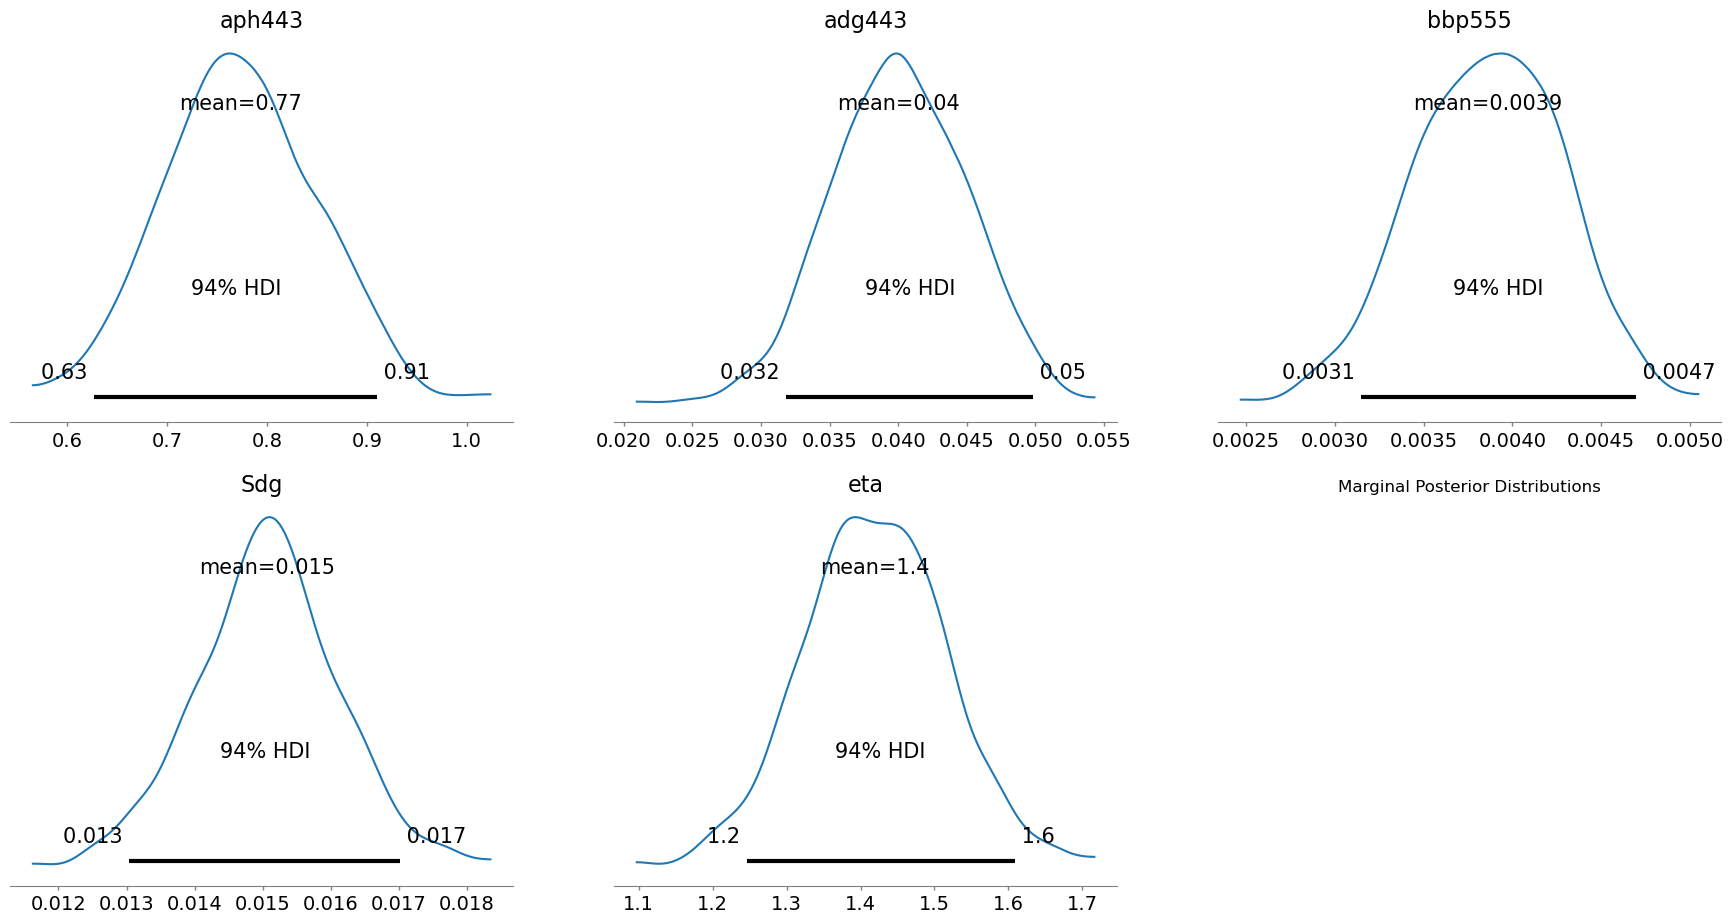

Text(0.5, 1.02, 'Pair Plot of Posterior Samples')

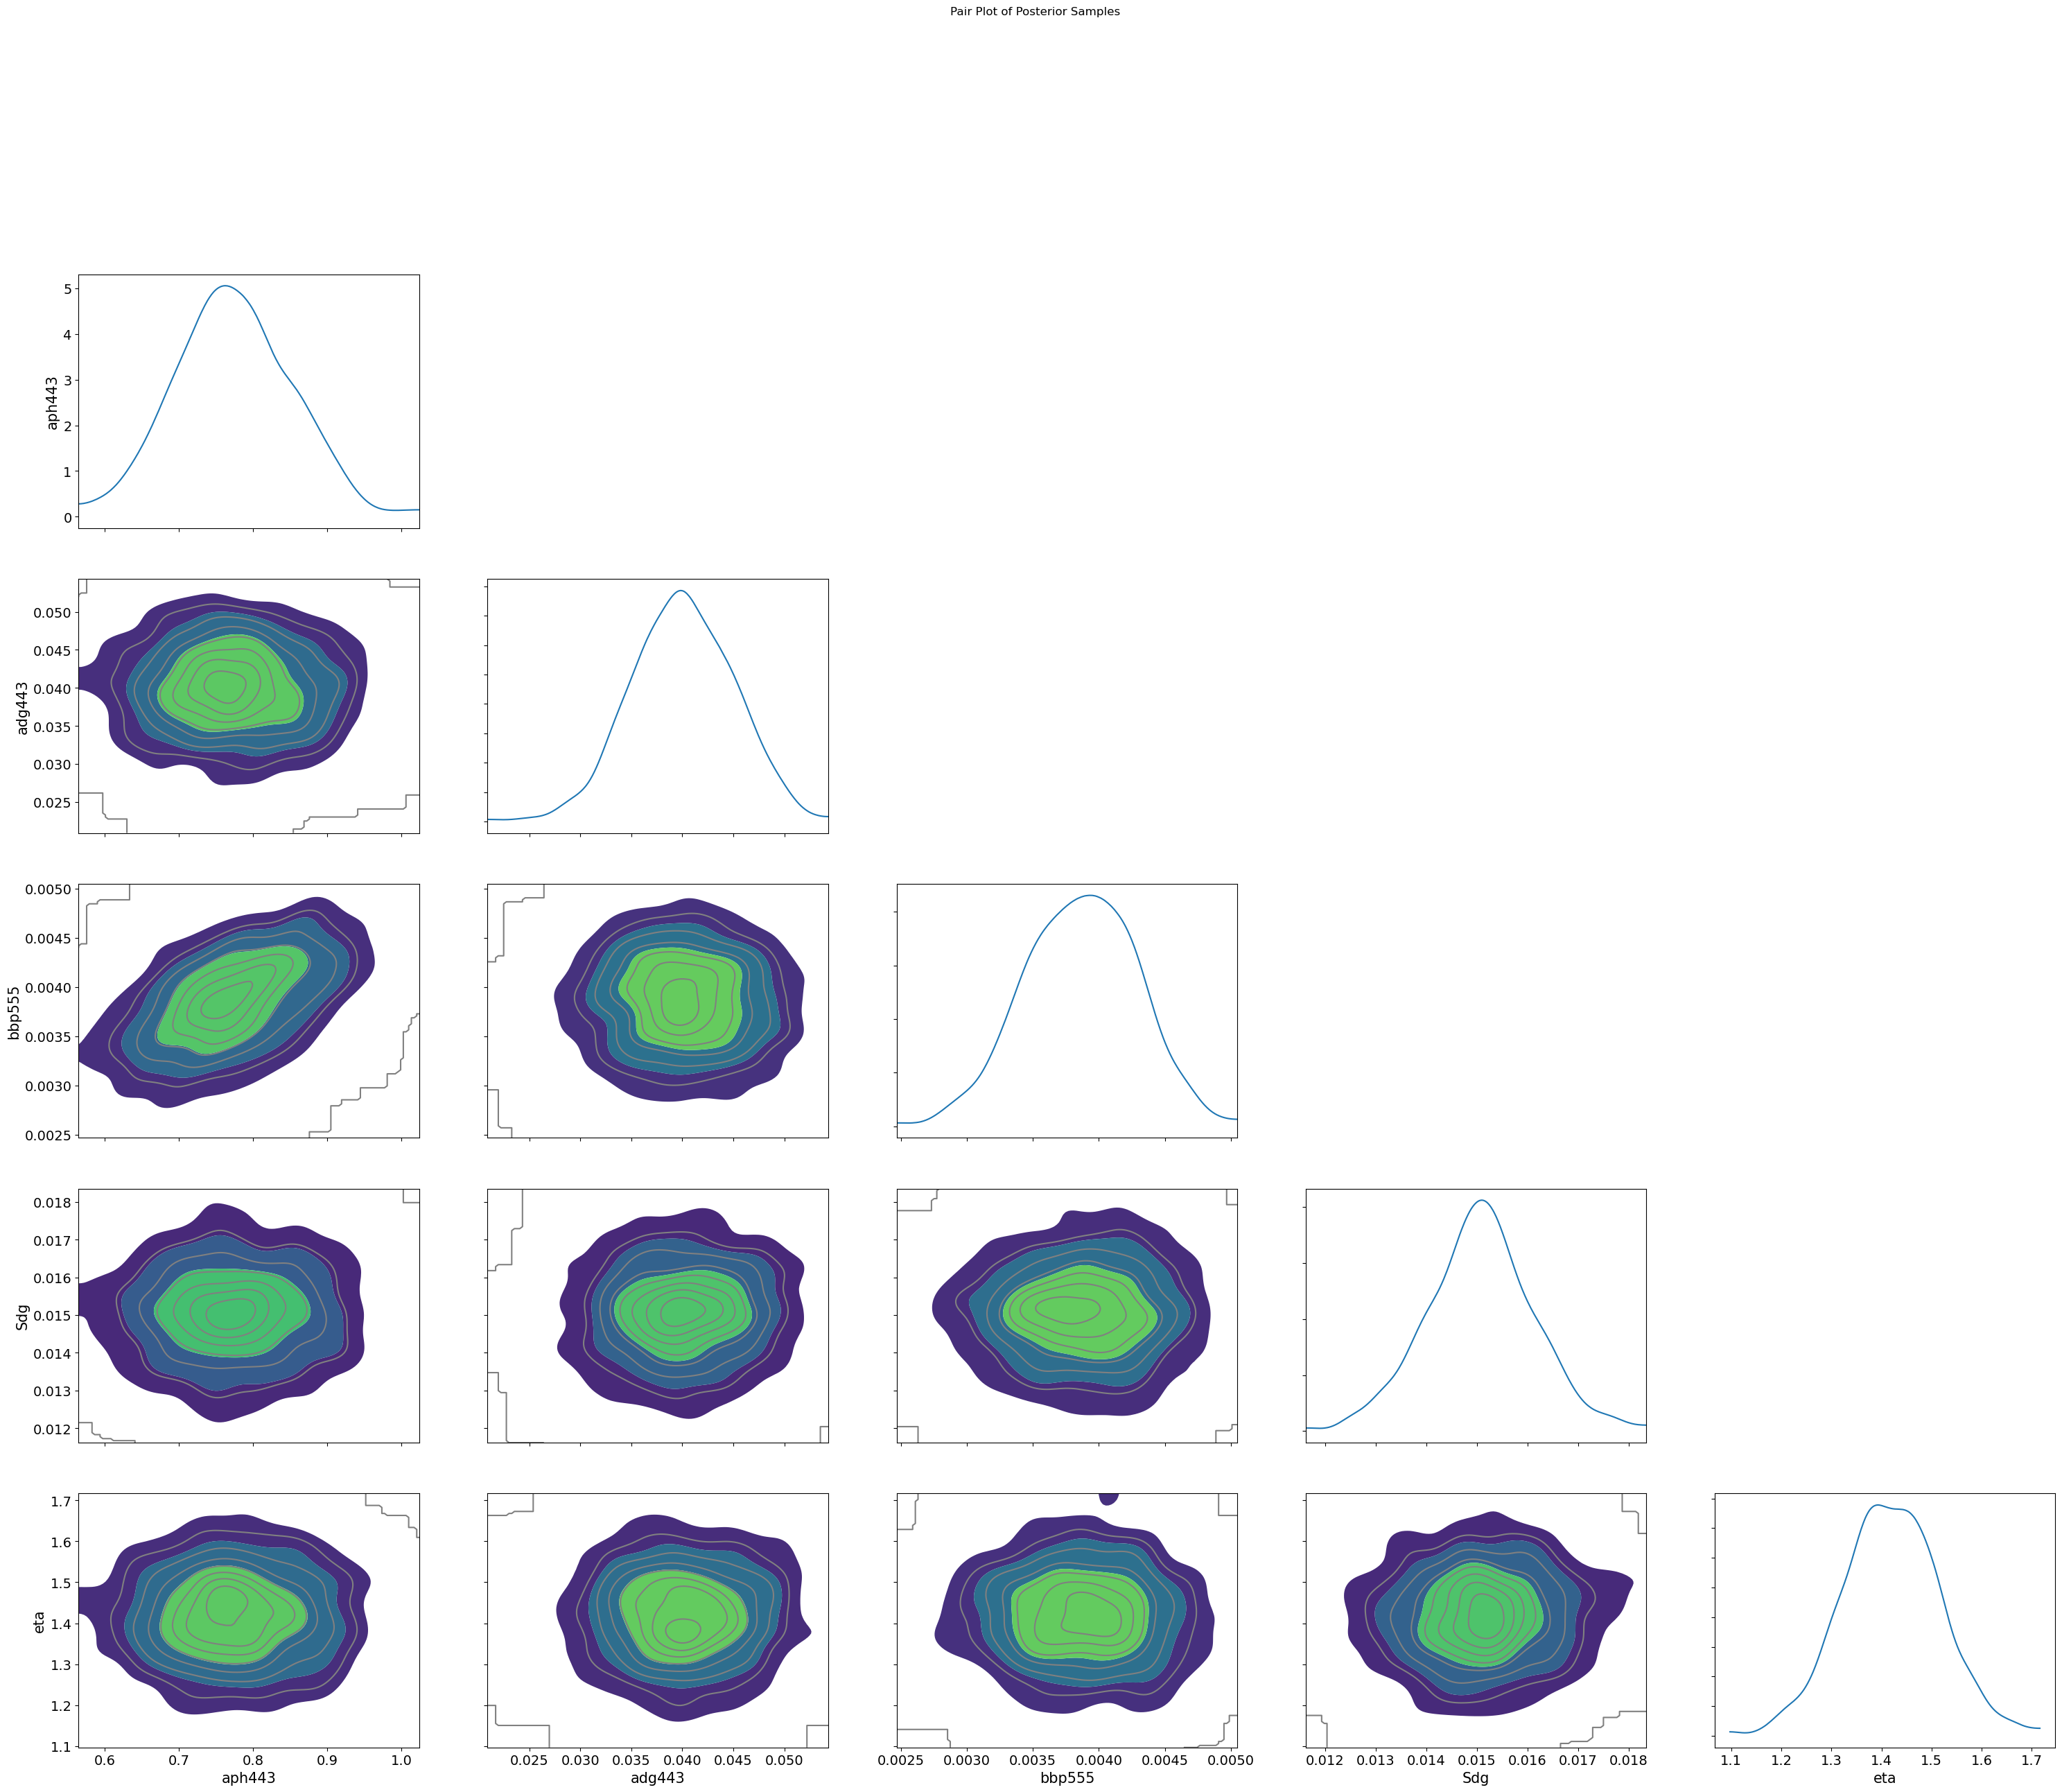

In [25]:
# Assume x_map and S_post are computed from the Bayesian-GIOP retrieval:
# For example, they might be:
# x_map = [aph(443), adg(443), bbp(555), Sdg, eta]
# S_post is the corresponding 5x5 posterior covariance matrix.

# Generate synthetic posterior samples from the Gaussian posterior
n_samples = 1000
posterior_samples = np.random.multivariate_normal(x_map_, S_post_, size=n_samples)

# Organize the samples into a dictionary with descriptive names
posterior_dict = {
    "aph443": posterior_samples[:, 0],   # Phytoplankton absorption at 443 nm (m^-1)
    "adg443": posterior_samples[:, 1],     # Combined detrital+gelbstoff absorption at 443 nm (m^-1)
    "bbp555": posterior_samples[:, 2],     # Particulate backscattering at 555 nm (m^-1)
    "Sdg":    posterior_samples[:, 3],     # Exponential slope for adg (nm^-1)
    "eta":    posterior_samples[:, 4]      # Backscattering spectral exponent (unitless)
}

# Convert the dictionary to an ArviZ InferenceData object
idata = az.from_dict(posterior=posterior_dict)

# Now, visualize the marginal posterior distributions for each parameter:
az.plot_posterior(idata)
pp.title("Marginal Posterior Distributions")
pp.show()

# Additionally, create a pair plot to inspect the joint distributions and correlations:
az.plot_pair(idata, kind="kde", marginals=True)
pp.suptitle("Pair Plot of Posterior Samples", y=1.02)

<Axes: >

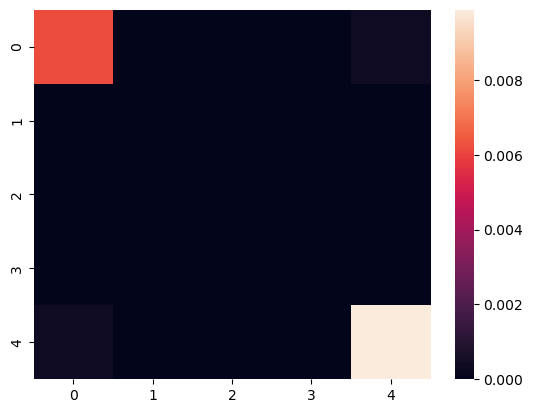

In [30]:
sb.heatmap(S_post_, vmin=S_post_.min(), vmax=S_post_.max())

In [29]:
S_post_.min(), S_post_.max()

(-7.734453451133038e-06, 0.0098845256205724)

Using pymc

In [ ]:
from pytensor import 

In [33]:
import pymc as pm
import pytensor.tensor as pt
from pymc import as_op

ImportError: cannot import name 'as_op' from 'pymc' (/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pymc/__init__.py)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


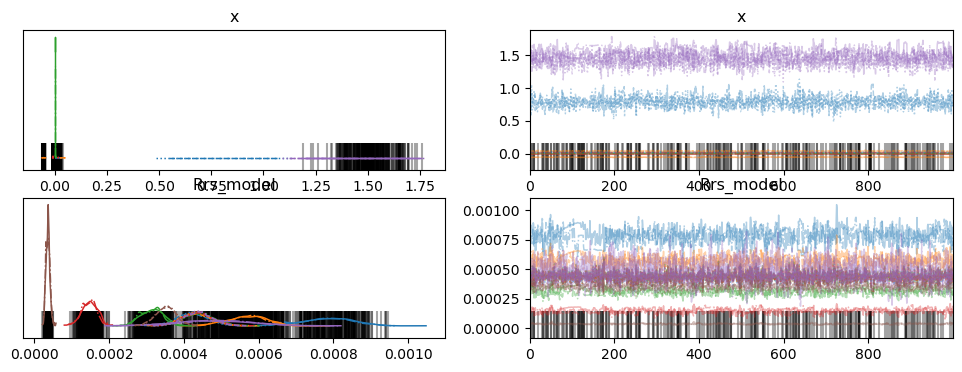

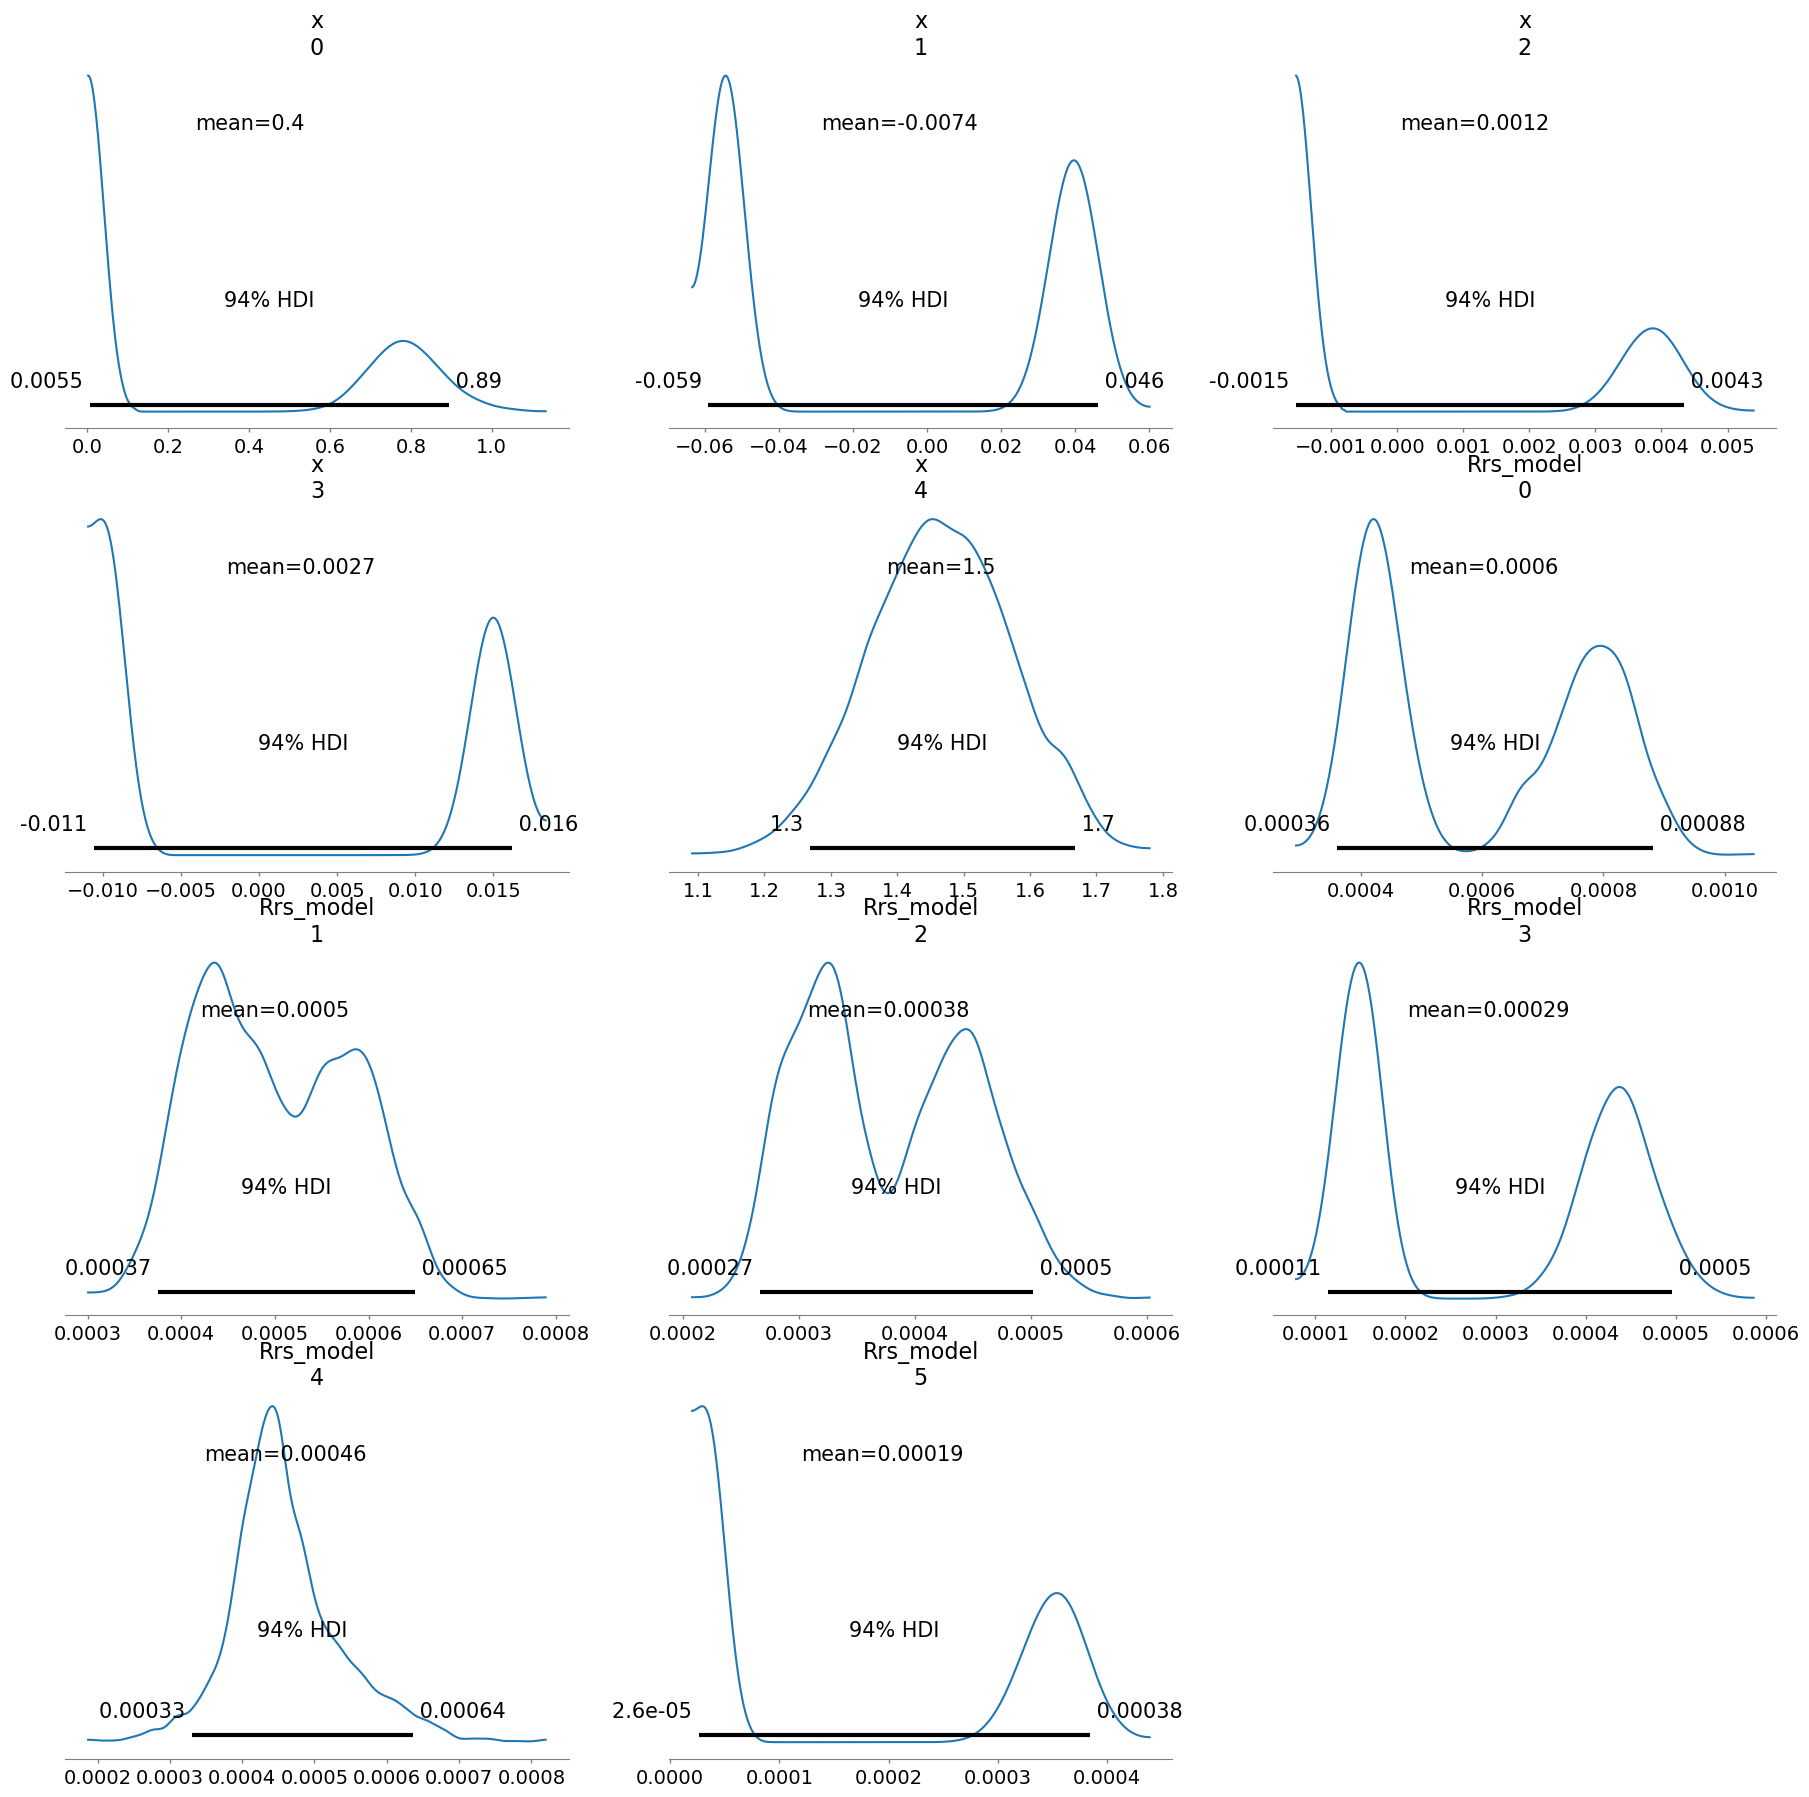

array([[<Axes: ylabel='x\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='x\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='x\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='x\n3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='x\n0', ylabel='x\n4'>, <Axes: xlabel='x\n1'>,
        <Axes: xlabel='x\n2'>, <Axes: xlabel='x\n3'>,
        <Axes: xlabel='x\n4'>]], dtype=object)

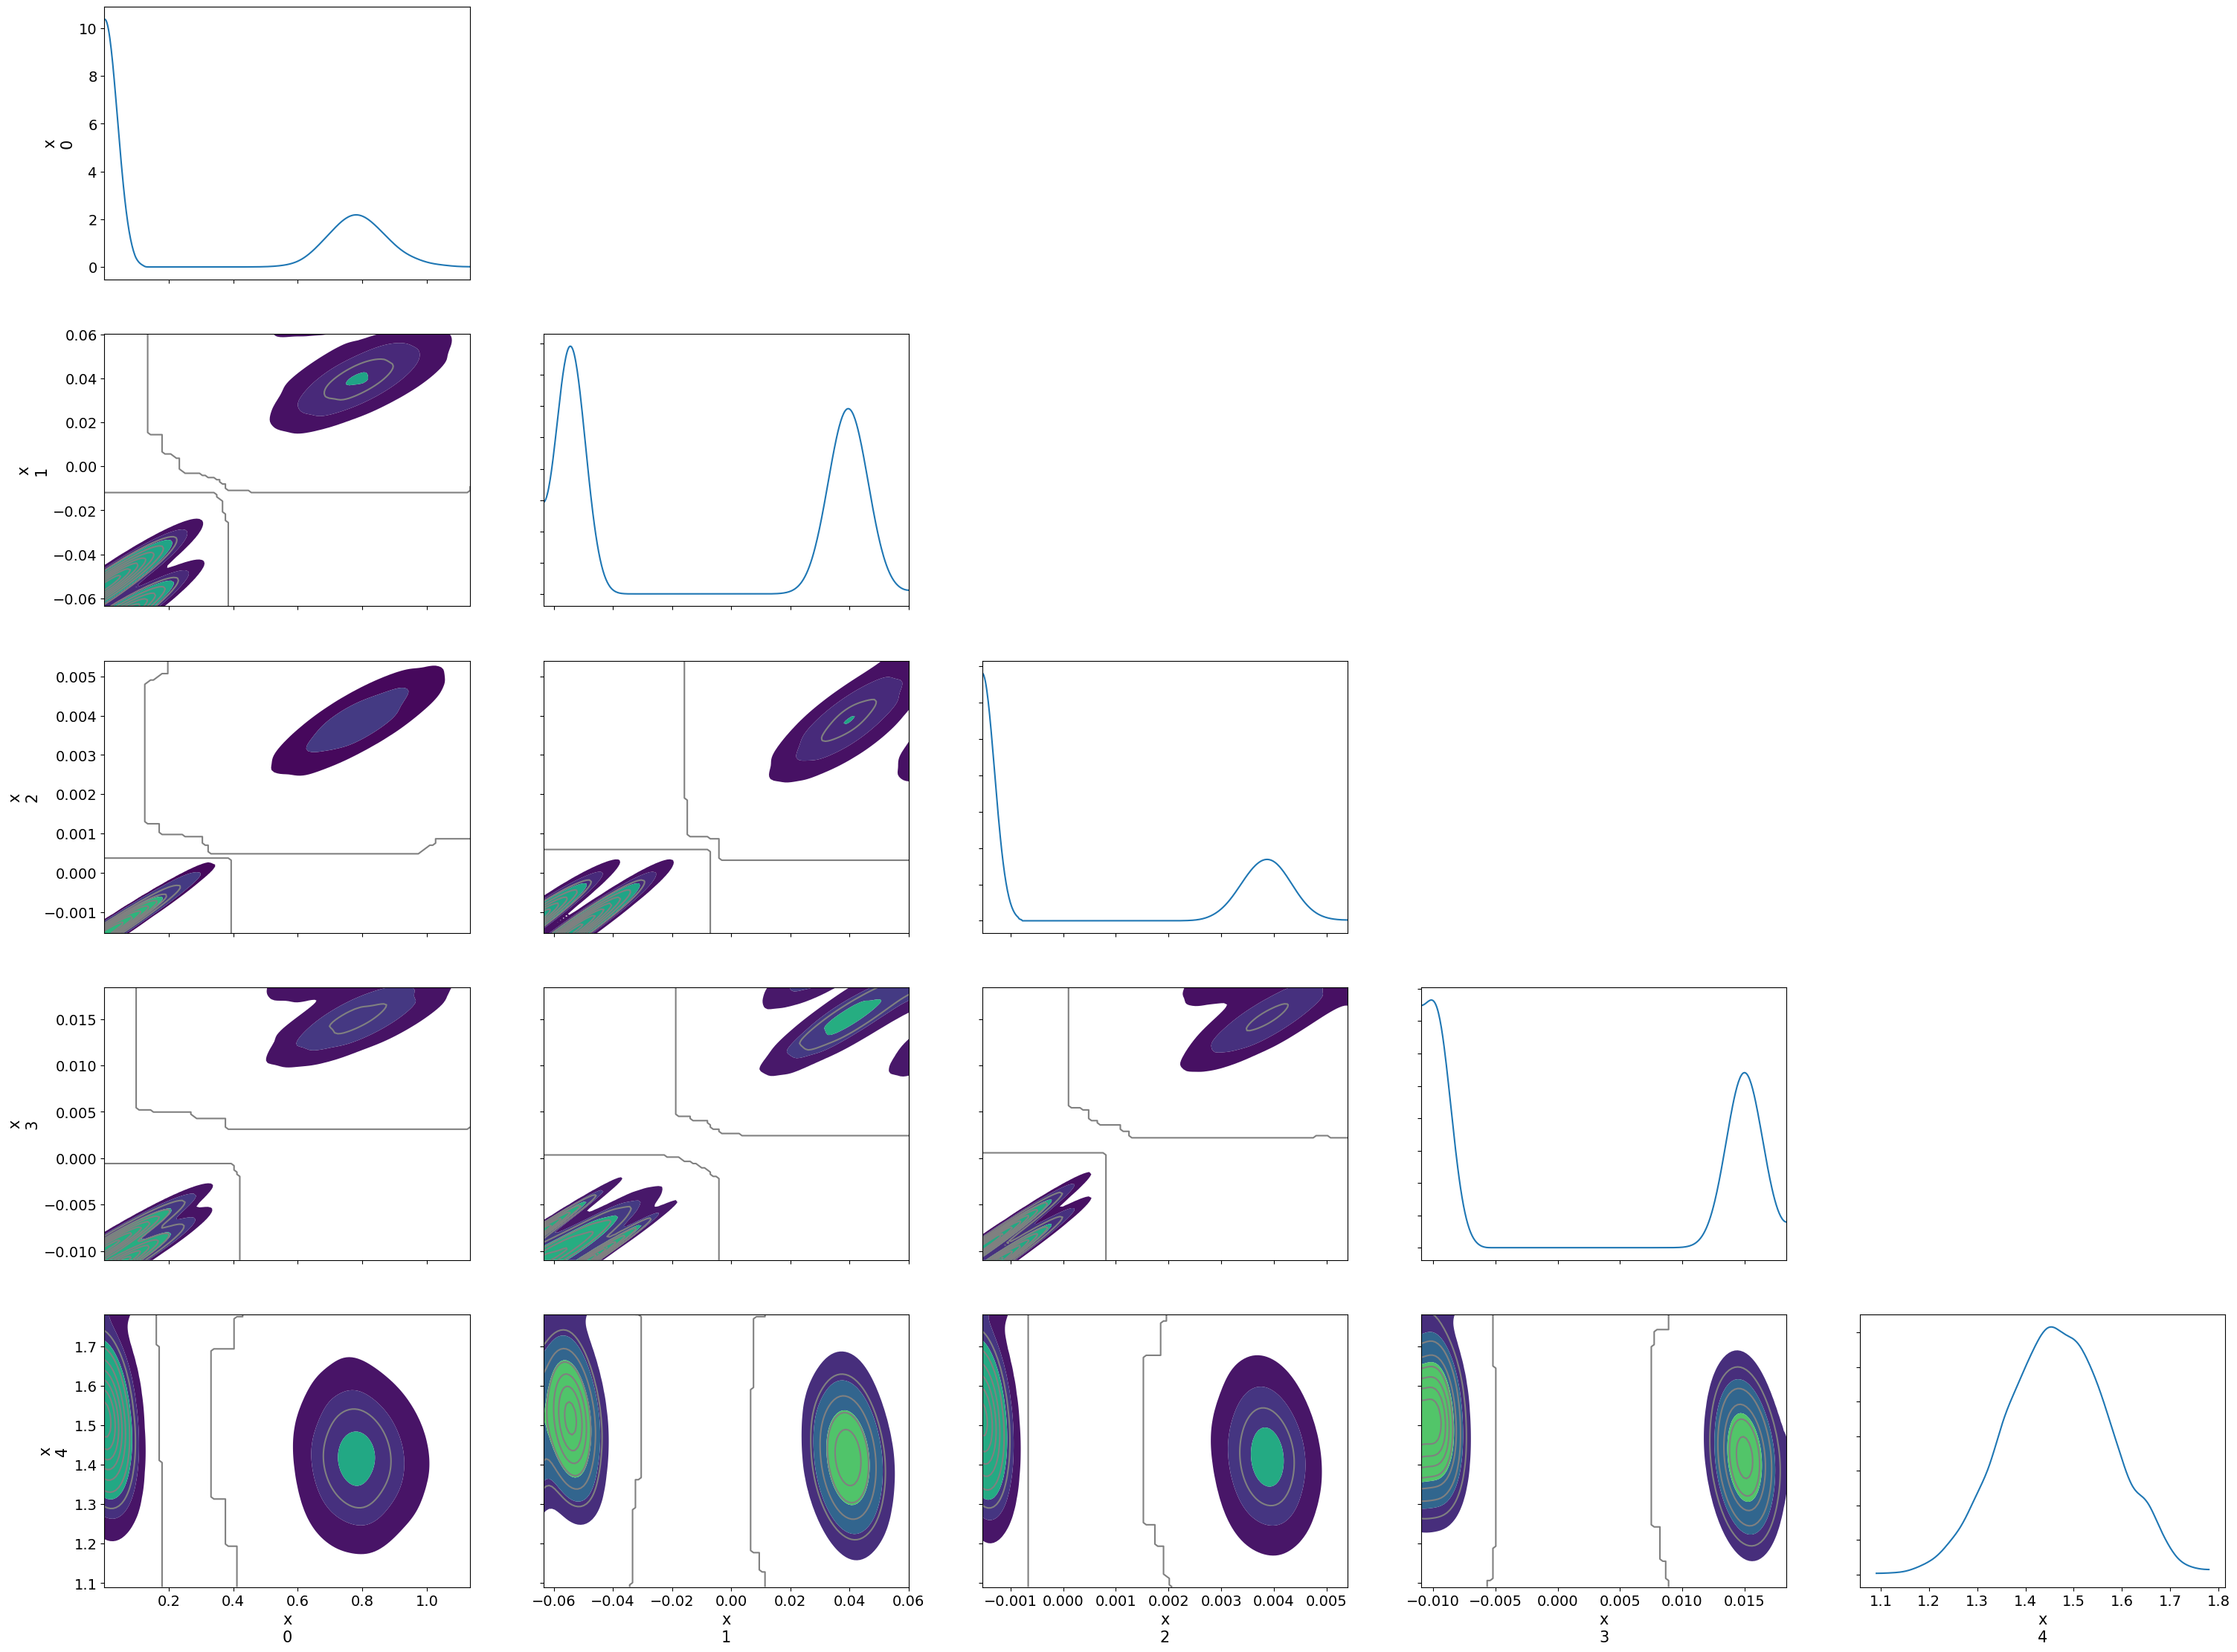

In [34]:
# --- Wrap the forward model in a PyTensor Op ---
# We fix wavelengths, aw, bbw, g1, and g2 by closure.
# The op must accept a vector x (state parameters) and return the Rrs (a vector).
#@as_op(itypes=[pt.dvector], otypes=[pt.dvector])
def forward_model_op(x):
    # Define constant arrays (example values)
    wavelengths = np.array([412, 443, 490, 510, 555, 670])
    aw = np.array([0.06, 0.07, 0.10, 0.12, 0.15, 0.30])    # water absorption (m^-1)
    bbw = np.array([0.003, 0.0025, 0.002, 0.0018, 0.0015, 0.001])  # water backscatter (m^-1)
    # Use the given radiative-transfer constants (as in our example)
    g1 = 0.0949
    g2 = 0.0794
    return forward_model_GIOP(x, wavelengths, aw, bbw, g1, g2)

# --- Simulate test NOMAD Rrs data ---
# For demonstration, we simulate a test record using our earlier functions.
# (In practice you would compute Rrs from the NOMAD CSV record: Rrs = lw / es)
test_Rrs = np.array([0.0004, 0.0005, 0.0006, 0.0007, 0.0005, 0.0003])
# Assume measurement uncertainty sigma_Rrs ~ 1e-4 (thus variance 1e-8)

# --- Define priors based on literature/test values ---
# Our parameter vector: x = [aph443, adg443, bbp555, Sdg, eta]
# Use example prior means similar to the 2023 "gold star" site:
x_prior = np.array([1.0, 0.04, 0.0029, 0.015, 1.4])
# Prior standard deviations (smaller uncertainties to reflect prior information)
prior_std = np.array([0.1, 0.005, 0.0005, 0.001, 0.1])

# --- Build the PyMC model ---
with pm.Model() as model:
    # Define independent priors for the 5 parameters (Gaussian priors)
    x = pm.Normal("x", mu=x_prior, sigma=prior_std, shape=5)
    
    # Use our forward model op to define the deterministic Rrs_model:
    Rrs_model = pm.Deterministic("Rrs_model", forward_model_op(x))
    
    # Define the likelihood: observed Rrs ~ Normal(mean=Rrs_model, sigma=1e-4)
    sigma_obs = 1e-4
    Rrs_obs = pm.Normal("Rrs_obs", mu=Rrs_model, sigma=sigma_obs, observed=test_Rrs)
    
    # Use the NUTS sampler to sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


In [ ]:

# --- Visualize the results using ArviZ ---
az.plot_trace(trace)
pp.show()

az.plot_posterior(trace)
plp.show()

az.plot_pair(trace, var_names=["x"], kind="kde", marginals=True)